In [1]:
repo_directory = '/Users/iaincarmichael/Dropbox/Research/law/law-net/'

data_dir = '/Users/iaincarmichael/Documents/courtlistener/data/'

import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from collections import Counter

# graph package
import igraph as ig

# our code
sys.path.append(repo_directory + 'code/')
from setup_data_dir import setup_data_dir, make_subnetwork_directory
from pipeline.download_data import download_bulk_resource, download_master_edgelist, download_scdb
from helpful_functions import case_info

sys.path.append(repo_directory + 'vertex_metrics_experiment/code/')
from rankscore_experiment_sort import *
from rankscore_experiment_LR import *
from rankscore_experiment_search import *

from make_tr_edge_df import *


# which network to download data for
network_name = 'scotus' # 'federal', 'ca1', etc


# some sub directories that get used
raw_dir = data_dir + 'raw/'
subnet_dir = data_dir + network_name + '/'
text_dir = subnet_dir + 'textfiles/'


# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load scotes
G = ig.Graph.Read_GraphML(subnet_dir + network_name +'_network.graphml')

In [3]:
# get a small sugraph to work wit
np.random.seed(234)
v = G.vs[np.random.choice(range(len(G.vs)))]

subset_ids = G.neighborhood(v.index, order=2)
g = G.subgraph(subset_ids)

In [41]:
# get adjacency matrix
A = np.array(g.get_adjacency().data)

# helper functions

In [56]:
def get_leading_evector(M, normalized=True):
    evals, evecs = np.linalg.eig(M)

    # there really has to be a more elegant way to do this
    return np.real(evecs[:, np.argmax(evals)].reshape(-1))

# parameters

In [44]:
n = len(g.vs)

case_years = np.array(g.vs['year']).astype(int)
Y = case_years - min(case_years) # zero index the years

m = max(Y) + 1

In [45]:
cases_per_year = [0] * m
cases_per_year_counter = Counter(Y)

for k in cases_per_year_counter.keys():
    cases_per_year[k] = cases_per_year_counter[k]
    
n_inv = [0 if cases_per_year[i] == 0 else 1.0/cases_per_year[i] for i in range(m)]

In [46]:
p = .15
qtv = .8
qvt = .1

# PageRank transition matrix

In [47]:
# set up the page rank transition matrix

D = np.diag([0 if d == 0 else 1.0/d for d in g.outdegree()])

z = [1.0/n if d == 0 else (1.0 - p) / n for d in g.outdegree()]

PR = p * np.dot(A.T, D) + np.outer([1] * n, z)

In [59]:
pr = get_leading_evector(PR)
pr = pr/sum(pr) # scale to probability

In [60]:
# check again igraph's page rank value
# TODO: still a little off
pr_ig = np.array(g.pagerank(damping = 1 - p))
print "sum square diff: %f " % sum(np.square(pr_ig - pr))
print "mean: %f" % np.mean(pr)

sum square diff: 0.002120 
mean: 0.004292


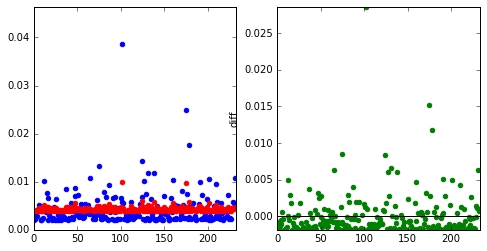

In [11]:
plt.figure(figsize=[8, 4])
plt.subplot(1,2,1)
plt.scatter(range(n), pr_ig, color='blue', label='igraph')
plt.scatter(range(n), pr, color='red', label='iain')
plt.xlim([0, n])
plt.ylim([0, 1.2 * max(max(pr_ig), max(pr))])

plt.subplot(1,2,2)
diff = pr_ig - pr
plt.scatter(range(n), diff, color='green')
plt.ylabel('diff')
plt.xlim([0, n])
plt.ylim(min(diff), max(diff))
plt.axhline(0, color='black')

# time-time transition matrix

ones on line below diagonal

In [12]:
TT = np.zeros((n, n))
TT[1:n, :n-1] = np.diag([1] * (n - 1))

# vertex - time transition matrix

the i-th column is the Y[i]th basis vector

In [13]:
VT = np.zeros((m, n))

# for basis vectors
identity_m = np.eye(m)


for i in range(n):
    VT[:, i] = identity_m[:, Y[i]]

# time - vertex transition matrix

VT transpose but entries are scaled by number of cases in the year

In [14]:
TV = np.zeros((n, m))

for i in range(n):
    TV[i, :] = identity_m[Y[i], :] * n_inv[Y[i]]

# Make overall transition matrix

In [21]:
P = np.zeros((n + m, n + m))

# upper left
P[:n, :n] = (1 - qvt) * PR

# upper right
P[:n, n:] = qtv * TV

# lower left
P[n:, :n] = qvt * VT

# lower right
P[:n, :n] = (1 - qtv)*TT

In [61]:
ta_pr = get_leading_evector(P)
ta_pr = ta_pr/sum(ta_pr)